## About the Task:

Guest Journey Patterns:
1. Use process mining or sequence analysis to identify common guest journey paths.
2. Compare these patterns across segments to uncover opportunities for personalization and operational improvements.


## About the Dataset

**Theme Park Attraction Visits Dataset**

Dataset Information:

This dataset comprises a set of users and their visits to various attractions in five theme parks (Disneyland, Epcot, California Adventure, Disney Hollywood and Magic Kindgom). The user-attraction visits are determined based on geo-tagged Flickr photos that are: (i) posted from Aug 2007 to Aug 2017 and retrieved using the Flickr API; (ii) then mapped to specific attraction location and attraction categories; and (iii) then grouped into individual travel sequences (consecutive user-attraction visits that differ by <8hrs). Other associated datasets are the "List of Attractions/POIs" dataset ("POI-{themeParkName}.csv" files from "poiList-sigir17.zip") and "Attraction/POI Cost-Profit Table" dataset ("costProfCat-{themeParkName}POI-all.csv" files from "costProf-sigir17.zip").

All user-attraction visits in each themepark are stored in a single csv file that contains the following columns/fields:

- id (photoID): identifier of the photo based on Flickr.

- nsid (userID): identifier of the user based on Flickr.

- dateTaken: the date/time that the photo was taken (unix timestamp format).

- poiID: identifier of the attraction (Flickr photos are mapped to attraction based on their lat/long).

- poiTheme: category of the attraction (e.g., Roller Coaster, Family, Water, etc).

- poiFreq: number of times this attraction has been visited.

- rideDuration: the normal ride duration of this attraction.

- seqID: travel sequence no. (consecutive attraction visits by the same user that differ by <8hrs are grouped as one travel sequence).

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# List files in your Google Drive
drive_path = "/content/drive/My Drive/Guest Journey Analysis/data"
os.listdir(drive_path)

['POI-disHolly.csv',
 'userVisits-disHolly-allPOI.csv',
 'userVisits-disland-allPOI.csv',
 'POI-caliAdv.csv',
 'userVisits-caliAdv-allPOI.csv',
 'data-sigir17.zip']

# Places of Interest

In [40]:
# Load the POI dataset
file_path = "/content/drive/My Drive/Guest Journey Analysis/data/POI-caliAdv.csv"
poi = pd.read_csv(file_path, delimiter=";")

In [39]:
# View the poi dataset
import plotly.express as px

# Create interactive scatter plot with POI indexes
fig = px.scatter(
    poi,
    x="long",
    y="lat",
    hover_name="poiName",
    hover_data={"rideDuration": True, "theme": True, "long": False, "lat": False},
    color="theme",
    text=poi.index,  # Show POI index as text on points
    title="<b>Disney California Adventure Park Attractions</b>",
    labels={"long": "Longitude", "lat": "Latitude"},
    width=1000,
    height=700,
)

# Customize hover tooltip
fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color="DarkSlateGrey")),
    hovertemplate=(
        "<b>%{hovertext}</b><br>"
        "Duration: %{customdata[0]} min<br>"
        "Theme: %{customdata[1]}<br>"
        "<extra></extra>"
    ),
    textposition="top center",  # Position index labels
)

# Improve layout
fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white",
    title_font=dict(size=20),
    hoverlabel=dict(bgcolor="white", font_size=12),
    legend_title_text="<b>Theme</b>",
    xaxis=dict(showgrid=True, gridcolor="lightgray"),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
)

# Add a small buffer to axis limits
fig.update_xaxes(range=[poi["long"].min() - 0.002, poi["long"].max() + 0.002])
fig.update_yaxes(range=[poi["lat"].min() - 0.001, poi["lat"].max() + 0.001])

# Show the plot
fig.show()


In [4]:
# Load the dataset
file_path = "/content/drive/My Drive/Guest Journey Analysis/data/userVisits-caliAdv-allPOI.csv"
df = pd.read_csv(file_path, delimiter=";")

# Check the first few rows
df.head()

,id,nsid,takenUnix,poiID,poiTheme,poiFreq,rideDuration,seqID
0,21636347373,10000151@N02,1445055661,17,Water,2110,420,1
1,8677571250,10004778@N07,1365918281,7,Family,2344,120,2
2,16998105937,10013542@N02,1429426348,17,Water,2110,420,3
3,9515529419,100344010@N06,1354336114,24,Family,6570,1500,4
4,14959134936,100373287@N02,1407466438,6,Kiddie,3509,120,5


We have 1972 distinct users for this dataset.

In [5]:
df["nsid"].nunique()

2593

In [6]:
df["id"].nunique()

57177

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57177 entries, 0 to 57176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            57177 non-null  int64 
 1   nsid          57177 non-null  object
 2   takenUnix     57177 non-null  int64 
 3   poiID         57177 non-null  int64 
 4   poiTheme      57177 non-null  object
 5   poiFreq       57177 non-null  int64 
 6   rideDuration  57177 non-null  int64 
 7   seqID         57177 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 3.5+ MB


## Data Preprocessing

In [8]:
# Convert UNIX timestamp to datetime
df["takenUnix"] = pd.to_datetime(df["takenUnix"], unit="s")

# Rename column for clarity
df.rename(columns={"takenUnix": "dateTaken"}, inplace=True)

# Sort the data
df = df.sort_values(by=["id", "dateTaken"])

# Display first few rows
df.head()

,id,nsid,dateTaken,poiID,poiTheme,poiFreq,rideDuration,seqID
34789,102530213,45561435@N00,2008-01-27 01:13:27,24,Family,6570,1500,3609
34788,102530244,45561435@N00,2008-01-27 01:12:31,18,Family,2177,540,3609
34787,102530263,45561435@N00,2008-01-27 01:11:40,7,Family,2344,120,3609
34786,102530315,45561435@N00,2008-01-27 01:10:53,18,Family,2177,540,3609
34785,102530334,45561435@N00,2008-01-27 01:09:32,18,Family,2177,540,3609


In [9]:
# Drop any missing values
df = df.dropna()

# Check if there are duplicate entries
df.duplicated().sum()

np.int64(0)

# Prepare temporal features
Rationale for temporal analysis:  If opportunity zones consistently receive fewer photos across all seasons and years, it suggests structural factors rather than seasonal variation.

In [10]:
from geopy.distance import great_circle

#convert poiID in df to integer
df['poiID'] = df['poiID'].astype(int)

# Merge photos_df with poi_df on 'poiID'
merged_df = df.merge(poi[['poiID', 'poiName', 'lat', 'long']], on='poiID', how='left')

# Display the first few rows
print(merged_df.head())

          id          nsid           dateTaken  poiID poiTheme  poiFreq  \
0  102530213  45561435@N00 2008-01-27 01:13:27     24   Family     6570   
1  102530244  45561435@N00 2008-01-27 01:12:31     18   Family     2177   
2  102530263  45561435@N00 2008-01-27 01:11:40      7   Family     2344   
3  102530315  45561435@N00 2008-01-27 01:10:53     18   Family     2177   
4  102530334  45561435@N00 2008-01-27 01:09:32     18   Family     2177   

   rideDuration  seqID                         poiName        lat        long  
0          1500   3609  Disney Junior - Live on Stage!  33.807419 -117.918332  
1           540   3609              Mickey's Fun Wheel  33.805046 -117.922333  
2           120   3609          King Triton's Carousel  33.804540 -117.921177  
3           540   3609              Mickey's Fun Wheel  33.805046 -117.922333  
4           540   3609              Mickey's Fun Wheel  33.805046 -117.922333  


<Figure size 1200x600 with 0 Axes>

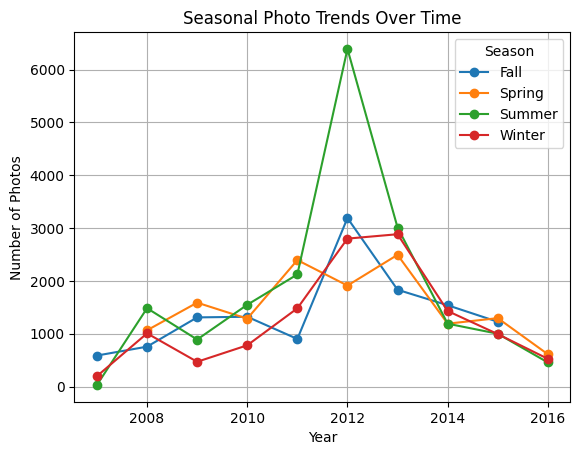

In [11]:
# Extract temporal features
df['year'] = df['dateTaken'].dt.year
df['month'] = df['dateTaken'].dt.month

# Define seasons (adjust as needed)
season_mapping = {12: "Winter", 1: "Winter", 2: "Winter",
                  3: "Spring", 4: "Spring", 5: "Spring",
                  6: "Summer", 7: "Summer", 8: "Summer",
                  9: "Fall", 10: "Fall", 11: "Fall"}

df['season'] = df['month'].map(season_mapping)

# Count photos per season over the years
seasonal_trends = df.groupby(['year', 'season']).size().unstack()

# Plot seasonal trends
plt.figure(figsize=(12, 6))
seasonal_trends.plot(marker='o')
plt.title('Seasonal Photo Trends Over Time')
plt.ylabel('Number of Photos')
plt.xlabel('Year')
plt.legend(title="Season")
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

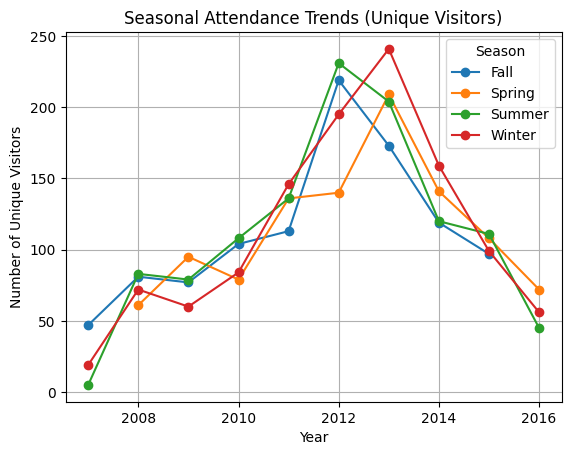

In [12]:
# Count unique users per season over the years
unique_visitors = df.groupby(['year', 'season'])['nsid'].nunique().unstack()

# Plot unique visitors trends
plt.figure(figsize=(12, 6))
unique_visitors.plot(marker='o')
plt.title('Seasonal Attendance Trends (Unique Visitors)')
plt.ylabel('Number of Unique Visitors')
plt.xlabel('Year')
plt.legend(title="Season")
plt.grid(True)
plt.show()

## Identify Guest Journey Sequences

In [41]:
! pip install pm4py
import pm4py
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import networkx as nx

In [15]:
# Ensure proper data types
df['dateTaken'] = pd.to_datetime(df['dateTaken'])  # Convert to datetime
df['poiID'] = df['poiID'].astype(str)  # Convert IDs to strings to avoid comparison issues

# Convert the dataframe to an event log format for process mining
event_log = df.copy()

# Sort the data by user and timestamp
event_log = event_log.sort_values(['nsid', 'dateTaken'])

# Create the required columns with proper formats
event_log_pm4py = pd.DataFrame({
    'case:concept:name': event_log['nsid'].astype(str),
    'concept:name': event_log['poiID'].astype(str),
    'time:timestamp': event_log['dateTaken']
})

# Convert to PM4Py event log format
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

event_log_pm4py = dataframe_utils.convert_timestamp_columns_in_df(event_log_pm4py)
log = log_converter.apply(event_log_pm4py)


## Visualising Guest Journey Patterns

### NetworkX



Most common multi-attraction journey patterns:
Frequency: 78, Pattern: 12 → 12
Frequency: 59, Pattern: 24 → 24
Frequency: 43, Pattern: 16 → 16
Frequency: 41, Pattern: 14 → 14
Frequency: 37, Pattern: 19 → 19


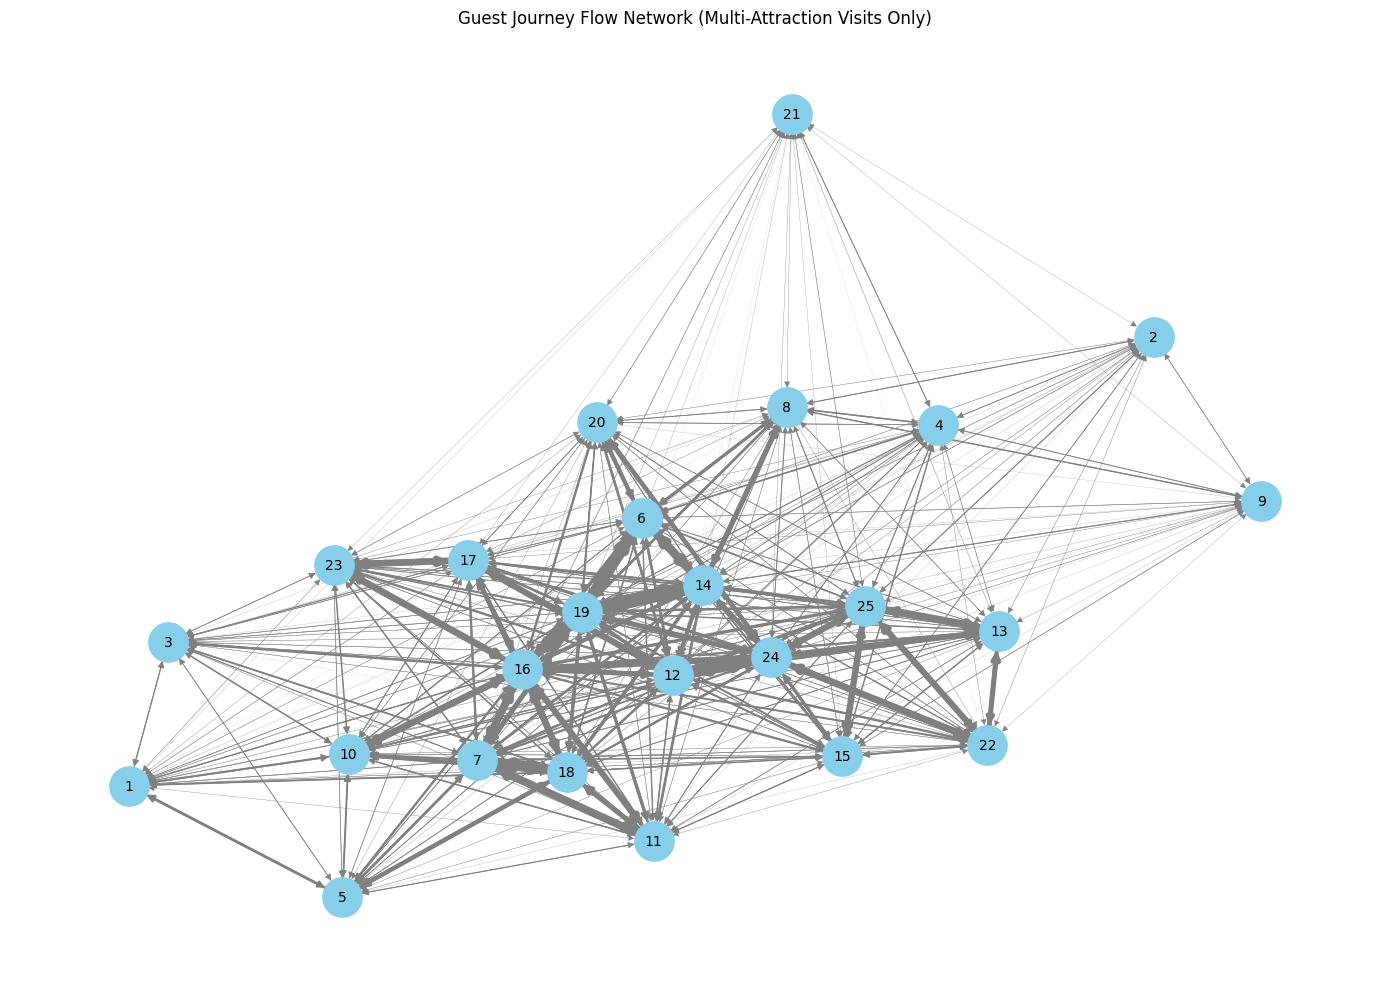


Top transitions for Family:
  1. 7 → 18 (frequency: 149)
  2. 18 → 7 (frequency: 140)
  3. 24 → 25 (frequency: 101)
  4. 25 → 24 (frequency: 89)
  5. 24 → 22 (frequency: 88)

Top transitions for Ride:
  1. 12 → 16 (frequency: 143)
  2. 16 → 12 (frequency: 127)
  3. 14 → 16 (frequency: 120)
  4. 12 → 14 (frequency: 104)
  5. 16 → 14 (frequency: 87)

Top transitions for Spinning Ride:
  1. 5 → 10 (frequency: 43)
  2. 10 → 5 (frequency: 22)

Top transitions for Roller Coaster:
  1. 15 → 11 (frequency: 41)
  2. 11 → 15 (frequency: 37)
  3. 3 → 11 (frequency: 22)
  4. 11 → 3 (frequency: 18)
  5. 3 → 15 (frequency: 9)

Top transitions for Show:
  1. 20 → 19 (frequency: 68)
  2. 19 → 20 (frequency: 52)

Top transitions for Kiddie:
  1. 23 → 6 (frequency: 46)
  2. 6 → 23 (frequency: 41)
  3. 2 → 6 (frequency: 18)
  4. 6 → 2 (frequency: 11)
  5. 23 → 2 (frequency: 6)


In [26]:
# Group attractions by visitor (nsid) and visit sequence (seqID)
visitor_journeys = {}
for visitor, visitor_data in df.groupby('nsid'):
    # Sort by dateTaken to get chronological order
    visitor_data = visitor_data.sort_values('dateTaken')

    # Group by seqID to separate different park visits
    for seq_id, seq_data in visitor_data.groupby('seqID'):
        journey_key = f"{visitor}_{seq_id}"
        visitor_journeys[journey_key] = list(seq_data['poiID'].astype(str))

# Count journey patterns (attraction sequences) - ONLY KEEP THOSE WITH >1 ATTRACTION
journey_patterns = {}
for journey in visitor_journeys.values():
    if len(journey) < 2:  # Skip single-attraction visits
        continue
    journey_str = ' → '.join(journey)
    journey_patterns[journey_str] = journey_patterns.get(journey_str, 0) + 1

# Show most common journey patterns (only multi-attraction)
print("\nMost common multi-attraction journey patterns:")
for pattern, count in sorted(journey_patterns.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Frequency: {count}, Pattern: {pattern}")

# Create transition graph (showing how guests move between attractions)
transitions = {}
for journey in visitor_journeys.values():
    if len(journey) < 2:
        continue
    for i in range(len(journey) - 1):
        source = journey[i]
        target = journey[i+1]
        if source != target:  # Only add if attractions are different
            transition = (source, target)
            transitions[transition] = transitions.get(transition, 0) + 1

# Create directed graph of transitions
G = nx.DiGraph()
for (source, target), weight in transitions.items():
    G.add_edge(source, target, weight=weight)

# Visualize the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducibility
edge_weights = [G[u][v]['weight']/max(transitions.values())*10 for u, v in G.edges()]

nx.draw_networkx(G, pos,
                node_color='skyblue',
                node_size=800,
                font_size=10,
                width=edge_weights,
                edge_color='gray',
                with_labels=True,
                arrows=True)
plt.title('Guest Journey Flow Network (Multi-Attraction Visits Only)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Analyze journeys by theme (multi-attraction sequences)
theme_transitions = {}
for theme in df['poiTheme'].unique():
    theme_df = df[df['poiTheme'] == theme]
    theme_transitions[theme] = {}

    for visitor, visitor_data in theme_df.groupby('nsid'):
        visitor_data = visitor_data.sort_values('dateTaken')
        for seq_id, seq_data in visitor_data.groupby('seqID'):
            journey = list(seq_data['poiID'].astype(str))
            if len(journey) < 2:
                continue
            for i in range(len(journey) - 1):
                source = journey[i]
                target = journey[i+1]
                if source != target:  # Only add if attractions are different
                    transition = (source, target)
                    if transition not in theme_transitions[theme]:
                        theme_transitions[theme][transition] = 0
                    theme_transitions[theme][transition] += 1

# Show top transitions for each theme (only multi-attraction)
for theme, transitions in theme_transitions.items():
    if transitions:
        print(f"\nTop transitions for {theme}:")
        sorted_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)
        for i, ((source, target), count) in enumerate(sorted_transitions[:5]):
            print(f"  {i+1}. {source} → {target} (frequency: {count})")

### **Popular Pairings & Guest Flow Insights**
1. **Family Attractions Dominate**  
   - **7 → 18 (Carousel → Mickey's Fun Wheel)** is the top transition, suggesting these classic family rides work well together.  
   - **Recommendation**: Bundle these in family itineraries or offer "Family Ride Pass" combos.

2. **Ride Synergies**  
   - **12 → 16 (Soarin' → Little Mermaid)** and **14 → 16 (Radiator Springs → Little Mermaid)** show guests favor transitioning from high-thrill to story-driven rides.  
   - **Recommendation**: Promote sequenced experiences (e.g., "Adventure to Fantasy" route).  

3. **Roller Coaster Loops**  
   - **15 ↔ 11 (Tower of Terror ↔ California Screamin')** indicates thrill-seekers revisit these.  
   - **Recommendation**: Offer "Thrill Seeker FastPass" for these paired coasters.  

4. **Show Circuit Efficiency**  
   - **20 ↔ 19 (Bug Show → Bakery Tour)** suggests guests cluster indoor shows.  
   - **Recommendation**: Schedule showtimes closer together to reduce walk time.  

5. **Kiddie Area Traffic**  
   - **23 ↔ 6 (Redwood Creek → Mater's Junkyard)** highlights playground-to-ride flow.  
   - **Recommendation**: Add shaded rest areas between these to extend dwell time.  

---

### **Operational Opportunities**
1. **Reduce Bottlenecks**  
   - High bidirectional transitions (e.g., **7 ↔ 18** which are Family rides that bring large crowds) may indicate congestion.  
   - **Action**: Direct crowd to other attractions, add queue entertainment

2. **Leverage Underutilized Paths**  
   - Weak transitions (e.g., **3 → 15**, despite being popular rides) could signal poor signage or distance.  
   - **Action**: Improve pathways or add "next stop" prompts near ride exits.  

3. **Food & Merchandise Placement**  
   - Pair F&B kiosks near high-traffic transitions
---

### **Marketing Strategies**
- **Theme-Based Packages**:  
  - "Family Fun Bundle": Carousel + Fun Wheel + Show tickets.  
  - "Coaster Lover Pass": Tower of Terror + California Screamin'.  

- **Dynamic Wait Times**:  
  - Notify guests via app when high-frequency pairs (e.g., **5 → 10**) have low waits.  

---

### **Data-Driven Expansion**  
- **Gaps in Transitions**: Few links between "Spinning Rides" and "Roller Coasters" suggest untapped cross-theme interest. Test mixed-theme events.  

**Key Metric to Watch**: If **24 → 22 (Disney Junior → Turtle Talk)** grows, expand indoor show capacity for rainy days.  

We now combine the Sequence dataset to the Places of Interest dataset to conduct analysis with location coordinates.

In [18]:
merged_df.head()

,id,nsid,dateTaken,poiID,poiTheme,poiFreq,rideDuration,seqID,poiName,lat,long
0,102530213,45561435@N00,2008-01-27 01:13:27,24,Family,6570,1500,3609,Disney Junior - Live on Stage!,33.807419,-117.918332
1,102530244,45561435@N00,2008-01-27 01:12:31,18,Family,2177,540,3609,Mickey's Fun Wheel,33.805046,-117.922333
2,102530263,45561435@N00,2008-01-27 01:11:40,7,Family,2344,120,3609,King Triton's Carousel,33.804540,-117.921177
3,102530315,45561435@N00,2008-01-27 01:10:53,18,Family,2177,540,3609,Mickey's Fun Wheel,33.805046,-117.922333
4,102530334,45561435@N00,2008-01-27 01:09:32,18,Family,2177,540,3609,Mickey's Fun Wheel,33.805046,-117.922333


# Opportunity Zone Analysis

A key way to manage congestion is to strategically disperse key attractions across the park which my teammate has developed a model for under subquestion B2: Optimization of Attraction Layouts and Schedules.

However, it is key to note that other attractions nearby to these hotspots should serve as a strong complement, rather than being neglected/ redundant.

They should help guests experience more once they have arrived in the vicinity of the hot spots, effectively reducing walking time and enhancing experience, increasing guest satisfaction.

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load your dataframe
plot_df = merged_df.copy()

# 1. Identify top attractions
top_attractions = plot_df['poiName'].value_counts().head(5).index.tolist()

# 2. Get exact coordinates of top attractions
top_coords = []
for attraction in top_attractions:
    attraction_coords = plot_df[plot_df['poiName'] == attraction][['lat', 'long']].iloc[0]
    top_coords.append((attraction_coords['lat'], attraction_coords['long']))

# 3. Mark whether each photo is at a top attraction location
plot_df['is_top_attraction'] = plot_df.apply(
    lambda row: (row['lat'], row['long']) in top_coords,
    axis=1
)

# 4. Calculate distance to nearest top attraction
def min_distance_to_top(row, top_coords):
    photo_coord = (row['lat'], row['long'])
    distances = [geodesic(photo_coord, top_coord).meters for top_coord in top_coords]
    return min(distances) if distances else np.nan

plot_df['distance_to_top'] = plot_df.apply(
    lambda row: min_distance_to_top(row, top_coords),
    axis=1
)


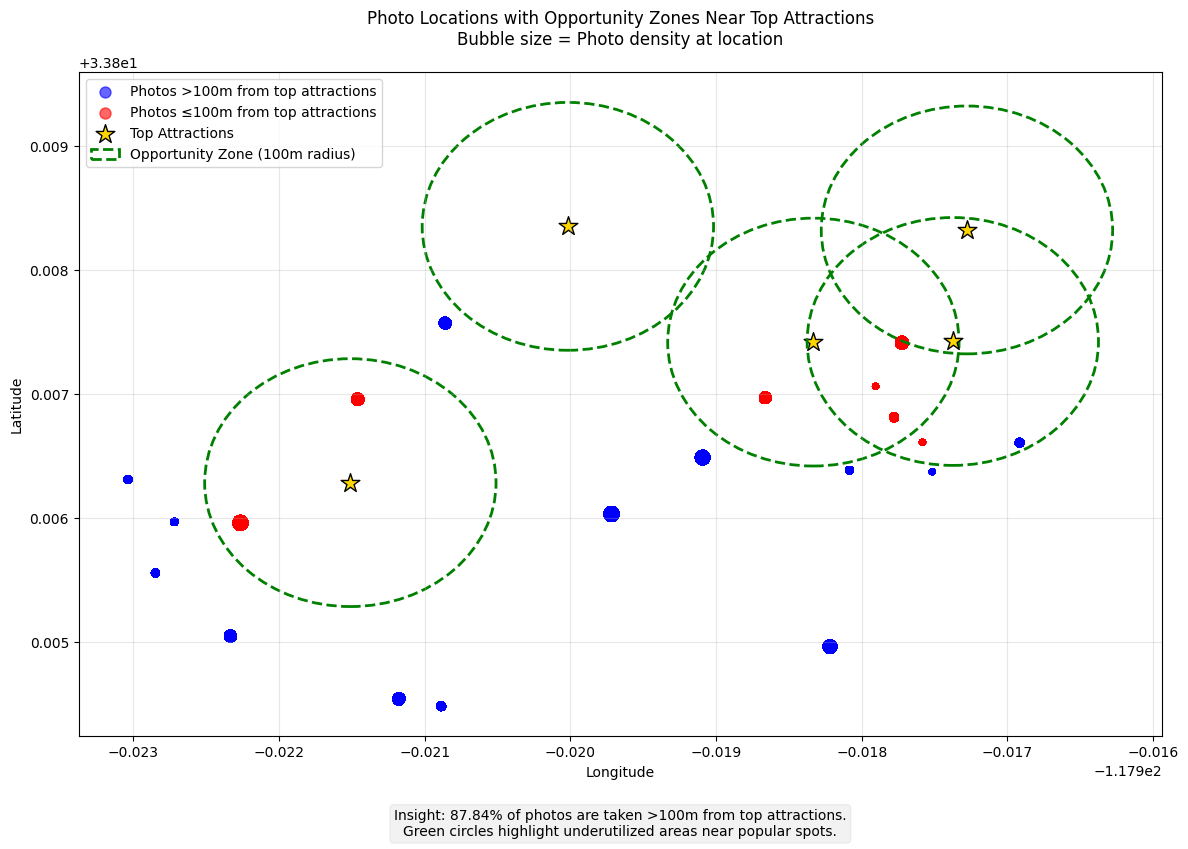

In [23]:
# 5. Categorize photos
plot_df['category'] = np.where(
    plot_df['distance_to_top'] <= 100,
    'Near top attraction (<100m)',
    'Far from top attraction (>100m)'
)

# 6. Calculate photo density (count at each unique coordinate)
coord_density = plot_df.groupby(['lat', 'long']).size().reset_index(name='density')
plot_df = plot_df.merge(coord_density, on=['lat', 'long'])

# 7. Create the plot with density-based bubbles
plt.figure(figsize=(12, 8))

# Main title with subtitle
plt.title(
    'Photo Locations with Opportunity Zones Near Top Attractions\n'
    'Bubble size = Photo density at location',
    pad=20
)

# A. Plot photos far from top attractions (>100m)
far_df = plot_df[plot_df['category'] == 'Far from top attraction (>100m)']
plt.scatter(
    x=far_df['long'],
    y=far_df['lat'],
    s=10 + 100 * (far_df['density'] / far_df['density'].max()),  # Bubble size scaled by density
    c='blue',
    alpha=0.6,
    label='Photos >100m from top attractions'
)

# B. Plot photos near top attractions (≤100m) - excluding top attractions themselves
near_df = plot_df[
    (plot_df['category'] == 'Near top attraction (<100m)') &
    (~plot_df['is_top_attraction'])
]
plt.scatter(
    x=near_df['long'],
    y=near_df['lat'],
    s=10 + 100 * (near_df['density'] / near_df['density'].max()),  # Bubble size scaled by density
    c='red',
    alpha=0.6,
    label='Photos ≤100m from top attractions'
)

# C. Highlight top attractions (gold stars)
for i, (lat, lon) in enumerate(top_coords):
    plt.scatter(
        lon, lat,
        c='gold',
        s=200,
        marker='*',
        edgecolors='black',
        label='Top Attractions' if i == 0 else None
    )
    # Draw opportunity zone circles
    plt.gca().add_patch(plt.Circle(
        (lon, lat),
        0.001,  # Approx 100m in degrees
        color='green',
        fill=False,
        linestyle='--',
        linewidth=2,
        label='Opportunity Zone (100m radius)' if i == 0 else None
    ))

# Add legend and labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add insight annotation
plt.annotate(
    f"Insight: 87.84% of photos are taken >100m from top attractions.\n"
    "Green circles highlight underutilized areas near popular spots.",
    xy=(0.5, -0.15),
    xycoords='axes fraction',
    ha='center',
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1, color="gray")
)

plt.show()

### **Key Insights from Opportunity Zones Analysis**  

#### **1. Underutilized Guest Flow Near Top Attractions**   
- **87.84% of guest traffic occurs >100m from top attractions**, suggesting inefficient distribution.  
- **Opportunity Zones (green circles)** highlight areas near high-demand rides (*Radiator Springs Racers, California Screamin'*) where foot traffic is sparse.  

**Recommendations**:  
- **Redirect Traffic Strategically**:  
  - Use signage or app prompts to guide guests toward underutilized paths (e.g., "Shorter wait times via Pier Route").  
  - Place food carts or shade structures in low-traffic zones to naturally draw crowds.  
- **Optimize Queue Design**:  
  - Extend queue lines into Opportunity Zones to reduce congestion at ride entrances.  

---

#### **2. Mismatch Between Ride Popularity and Adjacent Traffic**  
- High-transition ride pairs (e.g., *Soarin’ → Little Mermaid*) don’t correlate with dense traffic zones, indicating missed opportunities for ancillary spending.  

**Recommendations**:  
- **Place Merchandise Kiosks in High-Flow Gaps**:  
  - Add souvenir stands near transitions (e.g., between *Tower of Terror* and *California Screamin'*).  
- **Activate Dead Spaces**:  
  - Convert low-traffic areas into rest zones with charging stations or interactive displays.  

---

#### **3. Overcrowding in Family/Kiddie Zones**  
- *Redwood Creek Challenge Trail (23)* and *Mater’s Junkyard Jamboree (6)* have high transitions but limited space, risking bottlenecks.  

**Recommendations**:  
- **Stagger Entry Times**:  
  - Use virtual queues for playgrounds (*Redwood Creek*) during peak hours.  
- **Expand Pathways**:  
  - Widen walkways between *Mater’s Junkyard* and *Francis’ Ladybug Boogie* to improve flow.  

---

#### **4. Indoor vs. Outdoor Traffic Imbalance**  
- Indoor attractions (*Monsters, Inc., Turtle Talk*) show lower traffic density, likely due to capacity limits or lack of nearby amenities.  

**Recommendations**:  
- **Improve Indoor-Outdoor Transitions**:  
  - Add covered walkways or themed corridors to connect indoor rides to outdoor hubs.  
- **Enhance Pre-/Post-Experience Spaces**:  
  - Design outdoor lounges near indoor ride exits (e.g., *Bug’s Life* garden near *It’s Tough to Be a Bug!*).  

---

### **Actionable Business Strategies**  
1. **Pilot Traffic Redirection**: Test one-way paths during peak hours in Opportunity Zones to balance flow.  
2. **Dynamic Staffing**: Deploy more employees to manage crowds in high-transition zones (e.g., *Soarin’ → Little Mermaid*).  
3. **Leverage Real-Time Data**:  
   - Use IoT sensors to monitor traffic and adjust signage/operations dynamically.  

**Success Metric**: Reduce % of traffic >100m from top attractions (current 87.84% → target 70%).  

By aligning infrastructure and operations with these traffic patterns, you can enhance guest experience, reduce congestion, and maximize revenue opportunities.

In [27]:
from scipy.spatial import KDTree
from geopy.distance import great_circle

# Define high-traffic areas (top 10% most photographed locations)
top_locations = merged_df['poiID'].value_counts().nlargest(int(0.1 * len(merged_df['poiID'].unique()))).index
high_traffic_df = merged_df[merged_df['poiID'].isin(top_locations)][['lat', 'long']].drop_duplicates()

# Build a KDTree for high-traffic locations
high_traffic_tree = KDTree(high_traffic_df[['lat', 'long']].values)

# Query all locations in merged_df to check if they are within 100m
merged_df_coords = merged_df[['lat', 'long']].values
distances, _ = high_traffic_tree.query(merged_df_coords, distance_upper_bound=0.0009)  # Approx. 100m in degrees

# Assign a boolean flag if within 100m of a high-traffic area
merged_df['near_high_traffic'] = (distances != np.inf) & (~merged_df['poiID'].isin(top_locations))

# Compare photo counts
photo_counts = merged_df.groupby('near_high_traffic')['id'].count()
photo_percentage = (photo_counts / photo_counts.sum()) * 100

print("Photo distribution near high-traffic areas:")
print(photo_percentage)


Photo distribution near high-traffic areas:
near_high_traffic
False    87.839516
True     12.160484
Name: id, dtype: float64


In [28]:
# Count photos per location
photo_counts = merged_df.groupby(['poiID', 'poiName', 'lat', 'long']).size().reset_index(name='photo_count')

# Keep only locations near high-traffic areas but not high-traffic themselves
photo_counts = photo_counts[photo_counts['poiID'].isin(merged_df.loc[merged_df['near_high_traffic'], 'poiID'])]

# Filter for opportunity zones: locations with lower-than-median photo counts
median_photo_count = photo_counts['photo_count'].median()
opportunity_zones = photo_counts[photo_counts['photo_count'] < median_photo_count]

# Sort by least photographed
opportunity_zones = opportunity_zones.sort_values(by='photo_count', ascending=True)

print(opportunity_zones[['poiID', 'poiName', 'photo_count']].head(10))  # Top 10 least photographed locations


    poiID                      poiName  photo_count
20     21  Red Car Trolley & News Boys          162
3       4                Flik's Flyers          561
19     20      It's Tough to Be a Bug!         1178


### **Key Insights**
1. **Opportunity Zones Exist**  
   - Most photos (87.84%) are taken far (>100m) from high-traffic areas. This implies that some **nearby areas are underutilized** for visitor engagement.  
   - This aligns with the idea that **structural factors** (park design, visibility, attraction placement) influence where people take photos.  

2. **Potential for Enhancements**  
   - Disney might **improve signage, lighting, or experiences** in low-photo areas to encourage engagement.  
   - These locations could be leveraged for **new attractions, photo spots, or themed installations**.  

3. **Marketing & Crowd Flow Optimization**  
   - If **photo-taking correlates with guest movement**, areas **outside** high-traffic zones might be **less explored**.  
   - Disney could use this insight to distribute crowds better by **adding incentives or attractions in underutilized areas**.  